In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import itertools
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
pd.options.display.max_columns=300
pd.options.display.max_rows=100
# from TurbineTimeSeries.storage import MachineDataStore
plt.rcParams["figure.figsize"] = (14,8)
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin
%matplotlib inline

In [2]:
# model_number = 2

# store = MachineDataStore('.config')

# # model_data_hr = (store.query(model_number,'1hr')
# #                  .not_null(['timestamp','psn'])
# # #                  .exclude_psn([44,52,54,70])
# #                  .execute())

# model_data_min = (store.query(model_number,'10min')
#                   .not_null(['timestamp','psn'])
#                   .exclude_psn([44,52,54,70])
#                   .execute())

# model_data_min.head()
# model1_1hr = pd.read_csv('../../../data/raw_data_model1.csv',index_col=0)
# model2_1hr = pd.read_csv('../../../data/raw_data_model2.csv',index_col=0)

# model1_10min = pd.read_csv('../../../data/raw_data_model1_10min.csv',index_col=0)
model2_10min = pd.read_csv('../../../data/raw_data_model2_10min.csv')#,index_col=0)

## convert all to timestamps
# model1_1hr['timestamp'] = model1_1hr['timestamp'].apply(lambda x: pd.Timestamp(x))
# model2_1hr['timestamp'] = model2_1hr['timestamp'].apply(lambda x: pd.Timestamp(x))
# model1_10min['timestamp'] = model1_10min['timestamp'].apply(lambda x: pd.Timestamp(x))
model2_10min['timestamp'] = model2_10min['timestamp'].apply(lambda x: pd.Timestamp(x))


# print('Shape of model1 1hr data: ', model1_1hr.shape)
# print('Shape of model2 1hr data: ', model2_1hr.shape)
# print('Shape of model1 10min data: ', model1_10min.shape)
print('Shape of model2 10min data: ', model2_10min.shape)

Shape of model2 10min data:  (1602326, 76)


In [3]:
data_dictionary = pd.read_csv('data_dictionary_model2.csv')
data_dictionary

,COLUMN_NAME,SUBSYSTEM,SUGGESTED INDEPENDENT VARIABLES,MEASUREMENT_TYPE,DESCRIPTION,DATA TYPE
0,B_P1,GAS PATH,NaN,AMPLITUDE,Combustor dynamic pressure amplitude,float64
1,T5_S1,GAS PATH,YES,TEMPERATURE,Temperature spread (max T5 - min T5). Measured...,float64
2,T5_6,GAS PATH,NaN,TEMPERATURE,Temperature at T5,float64
3,T5_5,GAS PATH,NaN,TEMPERATURE,Temperature at T5,float64
4,T5_4,GAS PATH,NaN,TEMPERATURE,Temperature at T5,float64
5,T5_3,GAS PATH,NaN,TEMPERATURE,Temperature at T5,float64
6,T5_2,GAS PATH,NaN,TEMPERATURE,Temperature at T5,float64
7,T5_1,GAS PATH,NaN,TEMPERATURE,Temperature at T5,float64
8,C_C_T5_3,GAS PATH,NaN,VECTOR MAGNITUDE,Vector magnitude (sum of T5s),float64
9,C_C_T5_2,GAS PATH,NaN,TEMPERATURE SPREAD,Temperature spread (max T5 - min T5). Calculat...,float64


In [4]:
# [type(model2_10min.head()['timestamp'][0]) ## should be timestamp]
[i for i in data_dictionary['COLUMN_NAME'].str.lower().values if i not in model2_10min.columns.unique()]

['lo_c_brg1']

In [5]:
subsystem_dict = {str(i).lower(): list(data_dictionary[data_dictionary['SUBSYSTEM']==i]['COLUMN_NAME'].str.lower().values) for i in data_dictionary['SUBSYSTEM'].unique()}
del subsystem_dict['summary'] ## this group pretty useless

In [6]:
print(list(subsystem_dict.keys()))

['gas path', 'fuel', 'generator', 'vibration', 'lube oil system', 'enclosure', 'package equipment']


In [7]:
for i in subsystem_dict.keys():
    print(i,len(subsystem_dict[i]))

gas path 29
fuel 12
generator 12
vibration 6
lube oil system 8
enclosure 2
package equipment 1


In [8]:
def subsystem_pca(df,subsystem_dict,subsystems = [], psns = 'all'):
    if isinstance(subsystems,list)==True:
        if len(subsystems) > 0:
            pass
        else:
            raise Exception('Please give more than 0 subsystems')
    else: 
        raise Exception('Please give a list of subsystems')
        
    if psns == 'all' or isinstance(psns, (list, int))==True:
        pass
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
    subset = []
    for i in subsystems:
        subset = subset + subsystem_dict[i]
    available_subset = [i for i in subset if i in df.columns.values]
    if len(available_subset)<len(subset):
        print('excluding columns: ', list(set(subset)-set(available_subset)))
    available_subset =  available_subset + ['id','timestamp','psn']
    model_data = df[available_subset]
    
    skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
    index_cols = ['id','timestamp','psn']
    data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]
    
    missing_values = model_data.isnull().sum().sort_values()
    sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
    clean_data_cols = [x for x in data_cols if x not in sparse_cols]
    data = model_data[index_cols + clean_data_cols].dropna()#.reset_index()
    clean_data = StandardScaler().fit_transform(data[clean_data_cols])

    pca =  PCA().fit(clean_data)
    reduced = pca.transform(clean_data)
    reduced_df = pd.DataFrame(reduced)
    reduced_df['psn'] = data.psn.values
    reduced_df['timestamp'] = data.timestamp.values
    return(reduced_df)

In [9]:
def plot_eigs_subplots(reduced_df, n_eigs_x, n_eigs_y, psns, savefig = False,path=None,figname = None):
    if isinstance(n_eigs_x,int) == True:
        pass
    else:
        raise Exception('n_eigs_x must be an integer')
        
    if isinstance(n_eigs_y,int) == True:
        pass
    else:
        raise Exception('n_eigs_y must be an integer')
    

    
    if psns == 'all':
#         fig_base_title = 'All psns'
        pass
    elif isinstance(psns, list)==True:
        model2_10min[model2_10min['psn'].isin(psns)]
#         fig_base_title = 'PSN ' + str(psns)
        
    elif isinstance(psns,int) == True:
        reduced_df = reduced_df[reduced_df['psn']==psns]
#         fig_base_title = 'PSN ' + str(psns)
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
        
    if path == None:
        path = ''
    else:
        pass

        
    f, axarr = plt.subplots(n_eigs_x, n_eigs_y)
    f.set_figheight(20)
    f.set_figwidth(20)
    for i in range(n_eigs_x):
        for j in range(n_eigs_y):

            if i==j:
                continue
            axarr[i, j].scatter(reduced_df[i].values,reduced_df[j].values)
            axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
    if savefig == False:
        plt.show()
    else:
        f.suptitle(path + fname,fontsize=16)
        f.savefig(path+str('\\') + fname +'.png')      
#         f.suptitle(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots',fontsize=16)
#         f.savefig(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots.png')
#         plt.show()
        plt.close('all')

In [49]:
rd_df = subsystem_pca(model2_10min,subsystem_dict, ['enclosure'], psns = 'all')

FileNotFoundError: [Errno 2] No such file or directory: 'Eig Explorer\\All Psns ["gas path","fuel"] 5x5 subplots.png'

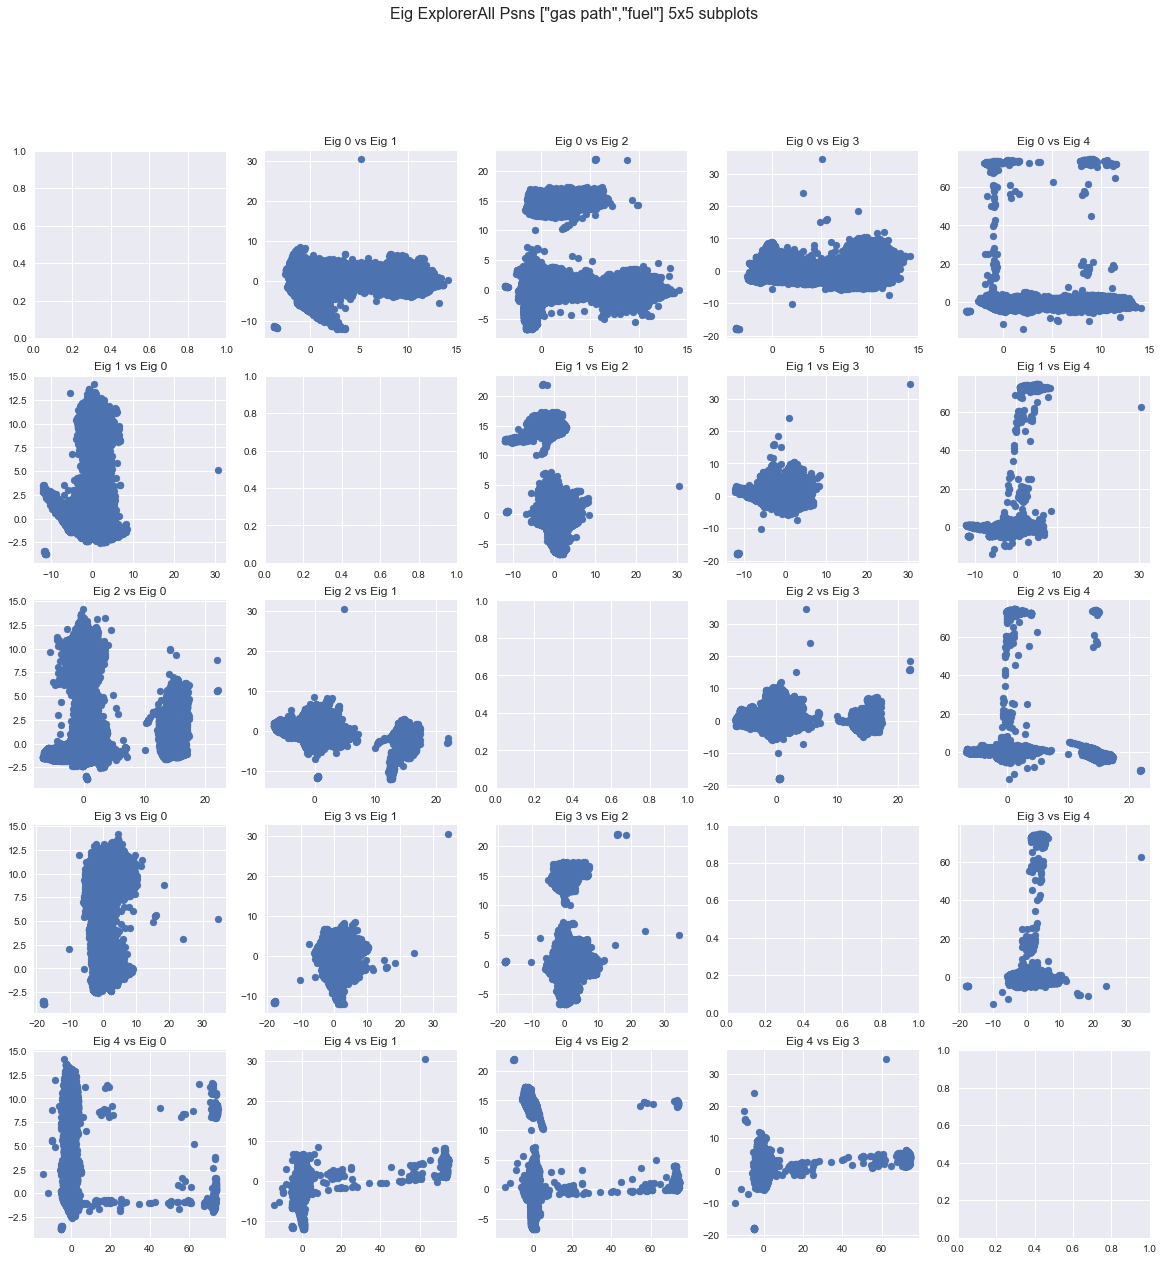

In [10]:
fname = 'All Psns ["enclosure"] ' + str(5) + 'x' + str(5) + ' subplots'
plot_eigs_subplots(reduced_df=rd_df,n_eigs_x=5,n_eigs_y=5,psns='all',savefig=True,path='Eig Explorer',figname = fname)

## looping through potential subsystems/tags to look for clusters in eigs

In [68]:
print(len(subsystem_dict.keys()))
print(subsystem_dict.keys())

7
dict_keys(['gas path', 'fuel', 'generator', 'vibration', 'lube oil system', 'enclosure', 'package equipment'])


In [9]:
combos = [list(subset) for L in range(1,len(subsystem_dict.keys())+1) for subset in itertools.combinations( subsystem_dict.keys(),L) ]
print(len(combos))

29


In [ ]:
# fig_base_title = 'All psns'
# f.suptitle(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots',fontsize=16)
# f.savefig(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots.png')

In [ ]:
# current_directory = os.getcwd()
# final_directory = os.path.join(current_directory,r'test')
# if not os.path.isdir(final_directory):
#     os.mkdir(final_directory)

In [64]:
# [j for i in subsystem_dict for j in subsystem_dict[i]]

In [65]:
[j for i in ['summary'] for j in subsystem_dict[i]]

['sum_enr', 'timestamp', 'sum_eng_st', 'sum_esn', 'sum_eng_h']

In [70]:
# folder_name_to_put_pictures_in = 'Eig_Explorer'

current_directory = os.getcwd()
final_directory = os.path.join(current_directory,r'Eig Explorer')
if not os.path.isdir(final_directory):
    os.mkdir(final_directory)

n_eigs_x = 5 ## me being lazy and defining them out here
n_eigs_y = 5

print('Saving Eigenvector Explorer subplot figures'+'\n')
for combo_cols in combos:
    max_eigs = len([j for i in combo_cols for j in subsystem_dict[i]])
    if max_eigs <5:
        n_eigs_x = max_eigs-1
        n_eigs_y = max_eigs-1
    else:
        n_eigs_x = 5 
        n_eigs_y = 5
        
    nao = time.time()
    print(str(combo_cols) + str('....'),end="",flush=True)
    rd_df = subsystem_pca(model2_10min,subsystem_dict, combo_cols, psns = 'all')
    fname = 'All Psns '+str(combo_cols) + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots'
    
    plot_eigs_subplots(reduced_df=rd_df,n_eigs_x=n_eigs_x,n_eigs_y=n_eigs_y,psns='all',savefig=True,path='Eig Explorer',figname = fname)
    print('Finished in {} seconds'.format(time.time()-nao))

Saving Eigenvector Explorer subplot figures

['gas path']....Finished in 120.45188927650452 seconds
['fuel']....Finished in 116.71467566490173 seconds
['generator']....Finished in 116.33865404129028 seconds
['vibration']....Finished in 115.13358521461487 seconds
['lube oil system']....excluding columns:  []
Finished in 115.16358709335327 seconds
['enclosure']....Finished in 0.7430422306060791 seconds
['package equipment']....Finished in 0.577033281326294 seconds
['gas path', 'fuel']....Finished in 122.91703033447266 seconds
['gas path', 'generator']....Finished in 122.51700758934021 seconds
['gas path', 'vibration']....Finished in 121.20093250274658 seconds
['gas path', 'lube oil system']....excluding columns:  []
Finished in 121.93997430801392 seconds
['gas path', 'enclosure']....Finished in 121.3269395828247 seconds
['gas path', 'package equipment']....Finished in 120.80991005897522 seconds
['fuel', 'generator']....Finished in 121.36494159698486 seconds
['fuel', 'vibration']....Finis

MemoryError: 

In [10]:
combos2 = [list(subset) for L in range(5,len(subsystem_dict.keys())+1) for subset in itertools.combinations( subsystem_dict.keys(),L) ]
print(len(combos))

29


In [11]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory,r'Eig Explorer')
if not os.path.isdir(final_directory):
    os.mkdir(final_directory)

n_eigs_x = 5 ## me being lazy and defining them out here
n_eigs_y = 5

print('Saving Eigenvector Explorer subplot figures'+'\n')
for combo_cols in combos2:
    max_eigs = len([j for i in combo_cols for j in subsystem_dict[i]])
    if max_eigs <5:
        n_eigs_x = max_eigs-1
        n_eigs_y = max_eigs-1
    else:
        n_eigs_x = 5 
        n_eigs_y = 5
        
    nao = time.time()
    print(str(combo_cols) + str('....'),end="",flush=True)
    rd_df = subsystem_pca(model2_10min,subsystem_dict, combo_cols, psns = 'all')
    fname = 'All Psns '+str(combo_cols) + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots'
    
    plot_eigs_subplots(reduced_df=rd_df,n_eigs_x=n_eigs_x,n_eigs_y=n_eigs_y,psns='all',savefig=True,path='Eig Explorer',figname = fname)
    print('Finished in {} seconds'.format(time.time()-nao))

Saving Eigenvector Explorer subplot figures

['gas path', 'fuel', 'generator', 'vibration', 'lube oil system']....excluding columns:  ['lo_c_brg1']
Finished in 132.195561170578 seconds
['gas path', 'fuel', 'generator', 'vibration', 'enclosure']....Finished in 131.88854384422302 seconds
['gas path', 'fuel', 'generator', 'vibration', 'package equipment']....Finished in 131.07249689102173 seconds
['gas path', 'fuel', 'generator', 'lube oil system', 'enclosure']....excluding columns:  ['lo_c_brg1']
Finished in 131.90254426002502 seconds
['gas path', 'fuel', 'generator', 'lube oil system', 'package equipment']....excluding columns:  ['lo_c_brg1']
Finished in 131.94054675102234 seconds
['gas path', 'fuel', 'generator', 'enclosure', 'package equipment']....Finished in 130.85348415374756 seconds
['gas path', 'fuel', 'vibration', 'lube oil system', 'enclosure']....excluding columns:  ['lo_c_brg1']
Finished in 131.1435010433197 seconds
['gas path', 'fuel', 'vibration', 'lube oil system', 'packag

In [19]:
model2_10min.columns.values

array(['timestamp', 'psn', 'id', 'lo_c_dp1', 'f_c_dp1', 'f_c_dp2',
       'f_c_dp5', 'pe_c_dt1', 'g_c_dt1', 'g_c_dt2', 'lo_c_dt5', 'c_dt5_1',
       'c_dt5_2', 'c_dt5_3', 'c_dt5_4', 'c_dt5_5', 'c_dt5_6',
       'sc_c_pct_e1', 'pe_c_pos_e1', 'f_c_pos_e2', 'f_c_pos_e1',
       'c_c_t5_1', 'c_c_t5_2', 'c_c_t5_3', 't5_s1', 'pe_p1', 'f_cmd1',
       'pe_t1', 'perf_pow', 'sum_eng_h', 'lo_p1', 'b_p1', 'g_t1', 't5_6',
       'g_t5', 'g_t4', 'v_d_1b', 'g_cur1', 'g_cur4', 'g_cur3', 'lo_t9',
       'f_cmd2', 'lo_t6', 't5_5', 't5_2', 't5_3', 't5_1', 'ngp', 'nt5',
       'pcd', 'v_acc1', 'sc_pct2', 'g_pow1', 'pe_for1', 'sc_pct1',
       'pe_cmd1', 'pe_pos1', 'g_cur2', 't1_1', 'sum_esn', 't5_4', 'f_p2',
       't5_a', 'sum_eng_st', 'lo_dp1', 'v_d_3b', 'f_p7', 'f_p1', 'v_d_2b',
       'lo_t5', 'g_t2', 'f_t1', 'sum_enr', 'g_t3', 'g_pct1', 'f_pos1'],
      dtype=object)

In [10]:
ind_var_cols = data_dictionary[data_dictionary['SUGGESTED INDEPENDENT VARIABLES']=='YES']['COLUMN_NAME'].str.lower().values
ind_var_cols = [str(i).lower() for i in ind_var_cols if i not in ['timestamp','sum_esn','sum_eng_st', 'sum_eng_h']]
# ind_var_combos = [list(i) for j in range(3,len(ind_var_cols)) for i in itertools.combinations(ind_var_cols,j)]
ind_var_combos = [list(i) for j in range(4,len(ind_var_cols)) for i in itertools.combinations(ind_var_cols,j)]

In [ ]:
len(ind_var_combos)

381

In [ ]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory,r'Eig Explorer ind var')
if not os.path.isdir(final_directory):
    os.mkdir(final_directory)

n_eigs_x = 5 ## me being lazy and defining them out here
n_eigs_y = 5
tempdict = {}
print('Saving Eigenvector Explorer subplot figures'+'\n')
for combo_cols in ind_var_combos[79:]:
    max_eigs = len(combo_cols)
    tempdict[str(combo_cols)]=combo_cols ## apologies for super hacky solution.
    if max_eigs <5:
        n_eigs_x = max_eigs-1
        n_eigs_y = max_eigs-1
    else:
        n_eigs_x = 5 
        n_eigs_y = 5
        
    nao = time.time()
    print(str(combo_cols) + str('....'),end="",flush=True)
    rd_df = subsystem_pca(model2_10min,tempdict, [str(combo_cols)], psns = 'all')
    fname = 'All Psns '+str(combo_cols) + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots'
    
    plot_eigs_subplots(reduced_df=rd_df,n_eigs_x=n_eigs_x,n_eigs_y=n_eigs_y,psns='all',savefig=True,path='Eig Explorer',figname = fname)
    print('Finished in {} seconds'.format(time.time()-nao))

Saving Eigenvector Explorer subplot figures

['lo_t6', 'perf_pow', 'sum_enr', 'ngp']....Finished in 37.45828413963318 seconds
['lo_t6', 'perf_pow', 'pcd', 'ngp']....Finished in 37.38794422149658 seconds
['lo_t6', 't5_a', 't1_1', 'sum_enr']....Finished in 37.023176431655884 seconds
['lo_t6', 't5_a', 't1_1', 'pcd']....Finished in 37.4947726726532 seconds
['lo_t6', 't5_a', 't1_1', 'ngp']....Finished in 41.95879411697388 seconds
['lo_t6', 't5_a', 'sum_enr', 'pcd']....Finished in 40.10367393493652 seconds
['lo_t6', 't5_a', 'sum_enr', 'ngp']....Finished in 45.095298290252686 seconds
['lo_t6', 't5_a', 'pcd', 'ngp']....Finished in 39.143680810928345 seconds
['lo_t6', 't1_1', 'sum_enr', 'pcd']....Finished in 37.39625930786133 seconds
['lo_t6', 't1_1', 'sum_enr', 'ngp']....Finished in 37.11730766296387 seconds
['lo_t6', 't1_1', 'pcd', 'ngp']....Finished in 37.854777336120605 seconds
['lo_t6', 'sum_enr', 'pcd', 'ngp']....Finished in 44.22350263595581 seconds
['lo_p1', 'perf_pow', 't5_a', 't1_1'].

In [41]:
model2_10min.columns

Index(['timestamp', 'psn', 'id', 'lo_c_dp1', 'f_c_dp1', 'f_c_dp2', 'f_c_dp5',
       'pe_c_dt1', 'g_c_dt1', 'g_c_dt2', 'lo_c_dt5', 'c_dt5_1', 'c_dt5_2',
       'c_dt5_3', 'c_dt5_4', 'c_dt5_5', 'c_dt5_6', 'sc_c_pct_e1',
       'pe_c_pos_e1', 'f_c_pos_e2', 'f_c_pos_e1', 'c_c_t5_1', 'c_c_t5_2',
       'c_c_t5_3', 't5_s1', 'pe_p1', 'f_cmd1', 'pe_t1', 'perf_pow',
       'sum_eng_h', 'lo_p1', 'b_p1', 'g_t1', 't5_6', 'g_t5', 'g_t4', 'v_d_1b',
       'g_cur1', 'g_cur4', 'g_cur3', 'lo_t9', 'f_cmd2', 'lo_t6', 't5_5',
       't5_2', 't5_3', 't5_1', 'ngp', 'nt5', 'pcd', 'v_acc1', 'sc_pct2',
       'g_pow1', 'pe_for1', 'sc_pct1', 'pe_cmd1', 'pe_pos1', 'g_cur2', 't1_1',
       'sum_esn', 't5_4', 'f_p2', 't5_a', 'sum_eng_st', 'lo_dp1', 'v_d_3b',
       'f_p7', 'f_p1', 'v_d_2b', 'lo_t5', 'g_t2', 'f_t1', 'sum_enr', 'g_t3',
       'g_pct1', 'f_pos1'],
      dtype='object')

In [46]:
freq = '10min'
## trying it out with only the gas path and fuel subsystems
gas_and_fuel_cols = subsystem_dict['gas path'] + subsystem_dict['fuel'] + ['id','timestamp','psn']
model_data = model2_10min[gas_and_fuel_cols]
len(model_data)

1602326

In [47]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [48]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [49]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [50]:
# data.head()

In [51]:
reduced_df = pd.DataFrame(reduced)

In [58]:
data_cols

['b_p1',
 't5_s1',
 't5_6',
 't5_5',
 't5_4',
 't5_3',
 't5_2',
 't5_1',
 'c_c_t5_3',
 'c_c_t5_2',
 'c_c_t5_1',
 'pe_pos1',
 'pe_for1',
 'pe_c_pos_e1',
 'pe_cmd1',
 't5_a',
 't1_1',
 'sc_pct2',
 'sc_pct1',
 'nt5',
 'c_dt5_6',
 'c_dt5_5',
 'c_dt5_4',
 'c_dt5_3',
 'c_dt5_2',
 'c_dt5_1',
 'sc_c_pct_e1',
 'pcd',
 'ngp',
 'f_c_pos_e2',
 'f_cmd2',
 'f_t1',
 'f_pos1',
 'f_p2',
 'f_p1',
 'f_c_pos_e1',
 'f_c_dp5',
 'f_c_dp2',
 'f_c_dp1',
 'f_cmd1',
 'f_p7']

In [52]:
reduced_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,-1.049197,-2.902590,-0.419462,-0.777406,0.442135,0.771463,-0.313536,0.021786,-0.699216,-0.150525,-0.645074,-0.003092,0.044361,-0.630129,0.403035,-1.143241,0.257445,0.397032,0.499124,-0.003072,0.342795,-0.556673,0.030015,-0.429204,0.136600,0.121283,-0.003446,2.785274e-07,-2.614414e-08,-2.674735e-10,6.053515e-10,6.097616e-11,8.278832e-11,-1.335147e-11,3.735925e-11,7.991599e-11,-1.142399e-11,-1.251001e-10,-4.649852e-11,-8.723516e-11,-1.479329e-10
1,-0.996596,-2.883268,-0.409189,-0.594401,0.358550,0.755767,-0.175690,0.287936,-0.695462,0.117221,-0.576167,0.181166,0.061670,-0.297598,0.371048,-1.184986,0.443722,0.491357,0.699483,-0.041850,0.425508,-0.349187,0.014755,-0.385188,0.075810,0.133921,0.002967,-8.892773e-08,-1.674068e-08,-1.777358e-10,5.404417e-10,-3.157167e-11,-1.793670e-11,-3.693144e-11,9.788480e-12,5.033883e-11,-5.613352e-12,-1.091947e-10,-3.321501e-11,-1.690409e-11,-4.552143e-11
2,-0.997133,-2.871571,-0.349649,-0.642846,0.292915,0.669901,-0.461856,-0.074959,-0.752947,-0.021224,-0.690202,0.260653,0.042862,0.162199,0.571548,-1.220835,0.563177,0.418860,0.732773,0.096523,0.428875,-0.346594,0.035033,-0.417181,0.098395,0.130191,0.008948,-3.337270e-07,-5.706271e-09,-1.733976e-10,5.828738e-10,-9.884263e-11,-9.538321e-11,-4.550465e-11,-5.872655e-13,4.586259e-11,2.521803e-12,-1.822926e-10,-4.097571e-11,4.296263e-12,-1.682224e-11
3,-1.026685,-2.877909,-0.408496,-0.617440,0.337938,0.842558,-0.060565,0.447867,-0.639427,0.270222,-0.596182,0.136625,0.061227,-0.422253,0.354074,-1.224104,0.481756,0.481699,0.453903,-0.040282,0.280906,-0.524591,-0.016394,-0.445143,0.063554,0.150500,0.004202,-8.868374e-08,-2.108825e-08,-2.059580e-10,6.339197e-10,-8.803472e-12,-1.232706e-11,-3.109267e-11,2.077000e-11,5.165552e-11,1.503680e-12,-1.310214e-10,-7.481618e-11,-3.177091e-11,-6.486240e-11
4,-1.047447,-2.925167,-0.434680,-0.718030,0.418384,0.854469,-0.190864,0.215481,-0.659428,0.051842,-0.597897,0.017724,0.061299,-0.711714,0.230674,-1.196518,0.296179,0.383113,0.480000,-0.092040,0.397636,-0.504342,0.024442,-0.419859,0.075615,0.135395,-0.004473,1.564685e-07,-2.659121e-08,-2.333158e-10,5.504409e-10,4.481785e-11,4.425382e-11,-1.822419e-11,2.282400e-11,6.601645e-11,-8.332084e-12,-9.151149e-11,-4.056560e-11,-6.276186e-11,-1.138270e-10


In [102]:
reduced_df.shape

(1602696, 72)

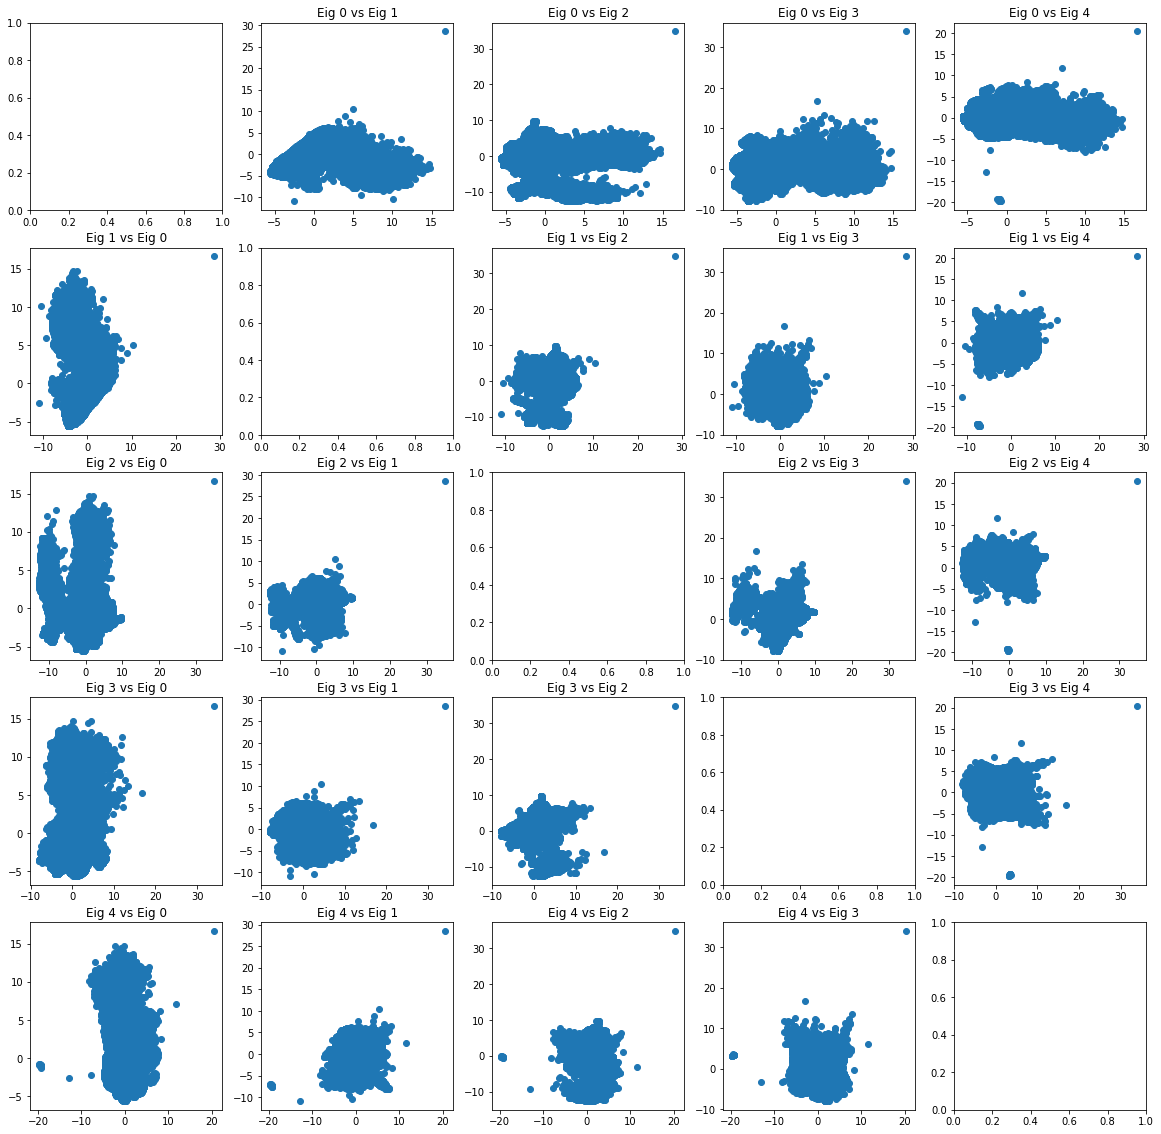

In [114]:
# %pyplot inline
f, axarr = plt.subplots(5, 5)
f.set_figheight(20)
f.set_figwidth(20)
for i in range(5):
    for j in range(5):
        if i==j:
            continue
        axarr[i, j].scatter(reduced_df[i].values,reduced_df[j].values)
        axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
# axarr[0, 1].scatter(x, y)
# axarr[0, 1].set_title('Axis [0,1]')
# axarr[1, 0].plot(x, y ** 2)
# axarr[1, 0].set_title('Axis [1,0]')
# axarr[1, 1].scatter(x, y ** 2)
# axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

In [108]:
# a = model2_10min[model2_10min['psn']==47]
# b = a[(a['timestamp']<='2017-09-28') & (a['timestamp']>='2017-09-14')]
# a.plot('timestamp','perf_pow')

In [109]:
# def roundTime(dt=None, roundTo=60):
#     """Round a datetime object to any time laps in seconds
#     dt : datetime.datetime object, default now.
#     roundTo : Closest number of seconds to round to, default 1 minute.
#     Author: Thierry Husson 2012 - Use it as you want but don't blame me.
#     """
#     if dt == None : dt = datetime.datetime.now()
#     seconds = (dt.replace(tzinfo=None) - dt.min).seconds
#     rounding = (seconds+roundTo/2) // roundTo * roundTo
#     return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
# n = datetime.datetime(2015,12,5,0,10,0,4)
# print(n)
# print(roundTime(n,600))

In [111]:
# eigenvectors_to_segment = 1
# half_hour_segments = []
# twelve_hour_segments = []
# #def half_hour_group(x):
#     #return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+str(x['hour'])+'-'+('0' if x['minute'] < 30 else '1')
# def twelve_hour_group(x):
#     return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+('0' if x['hour'] < 12 else '1')
# for i in range(eigenvectors_to_segment):
#     twelve_hour_segments.append([])
    
# ### Define which rows belong to which subset    
# for psn in sorted(data['psn'].unique()):
#     print(str(psn), datetime.datetime.now())
#     psn_data = pd.DataFrame(data[(data['psn'] == psn)])
#     psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
#     psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
#     psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
#     psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
#     print('\t time parsing done', datetime.datetime.now())
#     psn_data['twelve_hour_group'] = psn_data.apply(twelve_hour_group,1)
#     complete_groups = (psn_data.groupby(by=['twelve_hour_group']).count()['id'] == 72)
#     psn_data['complete_group'] = psn_data['twelve_hour_group'].apply(lambda x: complete_groups[x])
#     psn_data = psn_data[psn_data['complete_group'] == True]
#     print('\t block grouping done', datetime.datetime.now())
   
    #### TODO: SUBSET BY SUBSYSTEM
    
#     for d in psn_data['twelve_hour_group'].unique():
#         group_data = (psn_data[psn_data['twelve_hour_group'] == d]).sort_values(by='minute') ### SUBSETTING GOES HERE
#         idx = group_data.index
        
#         for i in range(eigenvectors_to_segment):
#             half_hour_segments[i].append([x for x in reduced[idx,i]])
    
#     print('\t block aggregating done', datetime.datetime.now())
   
 

In [48]:
psn_data.head(100)

,index,id,timestamp,psn,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,c_dt5_2,c_dt5_3,c_dt5_4,c_dt5_5,c_dt5_6,sc_c_pct_e1,pe_c_pos_e1,f_c_pos_e2,f_c_pos_e1,c_c_t5_1,c_c_t5_2,c_c_t5_3,t5_s1,pe_p1,f_cmd1,pe_t1,perf_pow,lo_p1,b_p1,g_t1,t5_6,g_t5,g_t4,v_d_1b,g_cur1,g_cur4,g_cur3,lo_t9,f_cmd2,lo_t6,t5_5,t5_2,t5_3,t5_1,ngp,nt5,pcd,v_acc1,sc_pct2,g_pow1,pe_for1,sc_pct1,pe_cmd1,pe_pos1,g_cur2,t1_1,t5_4,f_p2,t5_a,lo_dp1,v_d_3b,f_p7,f_p1,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,iso,hour,minute,twelve_hour_group,complete_group
1341120,1341164,421786,2016-06-07 00:00:00,72,0.235226,0.344489,0.107742,0.219318,0.223334,0.280001,0.284000,0.388235,-0.079834,0.006167,-0.003833,-0.043501,0.055500,0.065500,-0.069270,-0.063551,-0.001141,-0.02742,0.821310,0.249143,0.127516,0.174400,0.655291,0.061187,0.466667,0.372310,0.939819,0.073565,0.788572,0.834410,0.6796,0.6876,0.335567,0.820714,0.820848,0.823839,0.7575,0.528775,0.775000,0.832410,0.822543,0.820543,0.805343,1.000115,1.0,0.197685,0.200967,0.962648,0.8944,0.218477,-0.068667,0.329008,0.336859,0.821786,0.2845,0.812610,0.553221,0.821310,0.297439,0.269747,13.031339,0.547554,0.084776,0.682608,0.789714,0.3215,104.264304,0.6756,0.19861,0.062901,"(2016, 23, 2)",0,0,2016-23-2-0,True
1341121,1341165,421787,2016-06-07 00:10:00,72,0.249399,0.163568,0.317535,0.221964,0.218890,0.284000,0.281999,0.388235,-0.077111,0.005555,0.001555,-0.049778,0.054222,0.065555,-0.040934,-0.047400,-0.020100,-0.01280,0.820853,0.244572,0.119654,0.171200,0.655767,0.060899,0.463031,0.369557,0.940851,0.077077,0.789714,0.833964,0.6864,0.6896,0.338718,0.811473,0.812500,0.814911,0.7575,0.527590,0.775000,0.831697,0.821964,0.821164,0.805430,0.999771,1.0,0.196402,0.201987,0.961909,0.8921,0.243655,-0.068667,0.322725,0.330128,0.812946,0.2835,0.810897,0.552633,0.820853,0.315360,0.264924,13.073920,0.547138,0.085525,0.682608,0.789142,0.3135,104.325949,0.6808,0.19318,0.061699,"(2016, 23, 2)",0,10,2016-23-2-0,True
1341122,1341166,421788,2016-06-07 00:20:00,72,0.237538,0.335385,0.039471,0.219662,0.222222,0.279997,0.270000,0.385882,-0.075111,0.007555,-0.000111,-0.048111,0.046556,0.069222,-0.084132,-0.072950,0.049361,-0.00990,0.820107,0.247428,0.113691,0.173200,0.654807,0.062283,0.465455,0.378671,0.939819,0.073002,0.789142,0.833951,0.6876,0.6932,0.349035,0.838482,0.837946,0.841518,0.7575,0.535136,0.775625,0.829418,0.821618,0.820085,0.805085,0.998738,1.0,0.197431,0.211593,0.961538,0.8816,0.122640,-0.068667,0.324110,0.332051,0.839286,0.2840,0.810485,0.553221,0.820107,0.299999,0.271992,13.034184,0.548392,0.092391,0.682174,0.786286,0.3270,104.387722,0.6804,0.25419,0.062901,"(2016, 23, 2)",0,20,2016-23-2-0,True
1341123,1341167,421789,2016-06-07 00:30:00,72,0.249399,0.236676,0.192726,0.219754,0.220000,0.280001,0.277999,0.388235,-0.075223,0.008444,-0.004556,-0.040557,0.050777,0.061110,-0.007665,-0.060299,-0.044380,-0.02220,0.821403,0.233714,0.115790,0.163600,0.655767,0.061514,0.464848,0.374842,0.939819,0.073534,0.788572,0.833625,0.6880,0.6920,0.338511,0.823705,0.822411,0.826607,0.7570,0.530480,0.775000,0.831558,0.823092,0.820492,0.806358,0.999885,1.0,0.197431,0.205167,0.961538,0.8946,0.218477,-0.068667,0.328128,0.335897,0.824196,0.2845,0.813292,0.552042,0.821403,0.315360,0.270807,13.037028,0.546899,0.083137,0.682608,0.788000,0.3385,104.449747,0.6812,0.21249,0.062901,"(2016, 23, 2)",0,30,2016-23-2-0,True
1341124,1341168,421790,2016-06-07 00:40:00,72,0.249098,0.322302,0.221527,0.219250,0.222222,0.283997,0.279997,0.388235,-0.078278,0.005389,0.002722,-0.045612,0.050389,0.065389,-0.033330,-0.057449,-0.008160,-0.02354,0.821939,0.246286,0.115698,0.172400,0.654807,0.061430,0.465455,0.371203,0.940851,0.078569,0.789142,0.835017,0.6788,0.6976,0.336408,0.815223,0.815759,0.818393,0.7580,0.530339,0.774375,0.832017,0.823017,0.822484,0.806284,0.999885,1.0,0.197528,0.202433,0.961909,0.8945,0.201421,-0.068667,0.325357,0.333013,0.816429,0.2840,0.812817,0.552633,0.821939,0.315360,0.265681,13.024316,0.546060,0.085167,0.682174,0.788000,0.32

In [112]:
# len(twelve_hour_segments[0])

In [10]:
# for i in range(eigenvectors_to_segment):
#     twelve_hour_segments.append([])

# for psn in data['psn'].sort_values().unique():
#      print(str(psn), datetime.datetime.now())
#        psn_data = pd.DataFrame(data[(data['psn'] == psn)])
#        psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
#        psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
#        psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
#        psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
#        print('\t time parsing done', datetime.datetime.now())
#        psn_data['twelve_hour_group'] = psn_data.apply(twelve_hour_group,1)
#        complete_groups = (psn_data.groupby(by=['twelve_hour_group']).count()['id'] == 72)
#        psn_data['complete_group'] = psn_data['twelve_hour_group'].apply(lambda x: complete_groups[x])
#        psn_data = psn_data[psn_data['complete_group'] == True]
#        print('\t block grouping done', datetime.datetime.now())
  
#    for d in psn_data['twelve_hour_group'].unique():
#        group_data = (psn_data[psn_data['twelve_hour_group'] == d]).sort_values(by='minute')
#        idx = group_data.index
       
#        for i in range(eigenvectors_to_segment):
#            twelve_hour_segments[i].append([x for x in reduced[idx,i]])
   
#    print('\t block aggregating done', datetime.datetime.now())

In [11]:
# complete_groups

In [12]:
# def plot_cluster_distribution():
#     plt.rcParams["figure.figsize"] = (15,15)
#     fig = plt.figure(0)
#     ax1 = plt.subplot2grid((1,1), (0, 0))
#     ax1.bar(range(n_clusters),label_counts[:])
#     ax1.set_ylabel('Segment Count')
#     ax1.set_xlabel('Cluster')
#     plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, 30 Minute Profiles".format(model_number, j+1))
#     plt.grid("on")
#     fig.savefig("model{}_kmeans_{}_eig{}_30_min_cluster_distribution.png".format(model_number, n_clusters,j+1))
       
#     plt.show()
    
# def plot_cluster_grid():
#     plt.rcParams["figure.figsize"] = (15,15)
#     plt.show()

#     grid_size = (n_clusters,1)
#     cluster_means = []

#     fig = plt.figure(0)
#     row = -1
#     shared_ax = None

#     for i,c in enumerate(labels_sorted_by_freq):
#         cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
#         cluster_means.append(pd.DataFrame(cluster_data).mean())
        
#         col = i%15
#         row = row if col > 0 else row+1
        
#         ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
#         ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
#         plt.axis('off')
        
#         if shared_ax is None:
#             shared_ax = ax     

        
#     plt.suptitle("Model {} Eigenvector {}, 12 Hour Profiles".format(model_number, j+1))  
#     fig.savefig("model{}_kmeans_{}_eig{}_12_hr_cluster_grid.png".format(model_number, n_clusters,j+1))
#     plt.show()
#     plt.close()
    
# def plot_clusters(c_idx):
#     plt.rcParams["figure.figsize"] = (14, 7)
#     for i, c in enumerate(c_idx):
#         cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
#         fig = plt.figure(0)
#         ax = plt.subplot2grid((1,1), (0,0))
#         ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
#         ax.set_xlabel('Time of Day')
#         plt.suptitle("Model {} Eigenvector {},12 Hour Cluster {} ".format(model_number, j+1, i+1))  
#         fig.savefig("model{}_kmeans_{}_eig{}_12_hr_cluster{}.png".format(model_number, n_clusters,j+1, i+1))
#         plt.show
#         plt.close()
      

In [13]:
# for j, daily_coefficients in enumerate(half_hour_segments):
#     to_be_clustered = daily_coefficients
#     n_clusters=60

#     cluster = KMeans(n_clusters)
#     cluster.fit(to_be_clustered)
#     label_df = pd.DataFrame(cluster.labels_)
#     label_counts = label_df[0].value_counts().sort_values(ascending=False)
#     labels_sorted_by_freq = list(label_counts.keys())
    
#     plot_cluster_distribution()
#     plot_cluster_grid()
#     if j == 0:
#         plot_clusters(labels_sorted_by_freq)

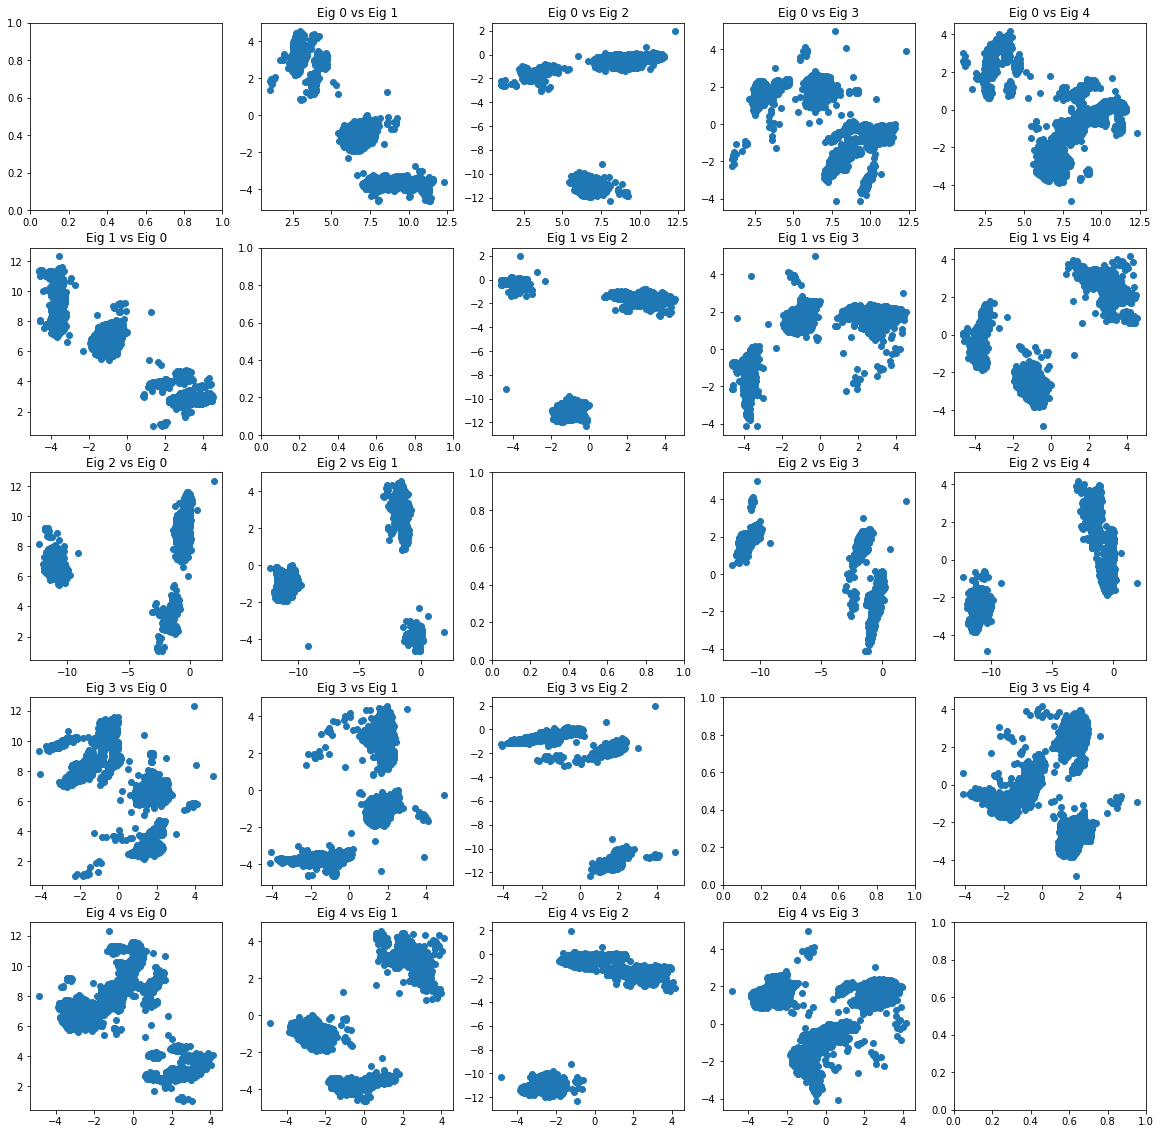

In [115]:
# %pyplot inline
f, axarr = plt.subplots(5, 5)
f.set_figheight(20)
f.set_figwidth(20)
for i in range(5):
    for j in range(5):
        if i==j:
            continue
        axarr[i, j].scatter(reduced_df[reduced_df['psn']==46][i].values,reduced_df[reduced_df['psn']==46][j].values)
        axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
# axarr[0, 1].scatter(x, y)
# axarr[0, 1].set_title('Axis [0,1]')
# axarr[1, 0].plot(x, y ** 2)
# axarr[1, 0].set_title('Axis [1,0]')
# axarr[1, 1].scatter(x, y ** 2)
# axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
# plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

In [ ]:
for i in range(5):
    for j in range(5):
        if i == j:
            continue
        plt.scatter(reduced_df[reduced_df['psn']==39][i].values,reduced_df[reduced_df['psn']==39][j].values)
        plt.show()

In [12]:
# reduced_
reduced_df['psn'] = data.psn.values
reduced_df['timestamp'] = data.timestamp.values

#reduced_df.set_index([data.psn.values, data.timestamp.values])

In [19]:
eig_df = reduced_df[['psn','timestamp',0]]
eig_df.columns = ['psn','timestamp','eig1']
eig_df.head()

,psn,timestamp,eig1
0,56,2017-01-02 13:49:59.999998,-3.061664
1,56,2017-01-02 14:00:00.000003,-2.977065
2,56,2017-01-02 14:09:59.999997,-3.014247
3,56,2017-01-02 14:20:00.000002,-2.888082
4,56,2017-01-02 14:29:59.999996,-3.058980


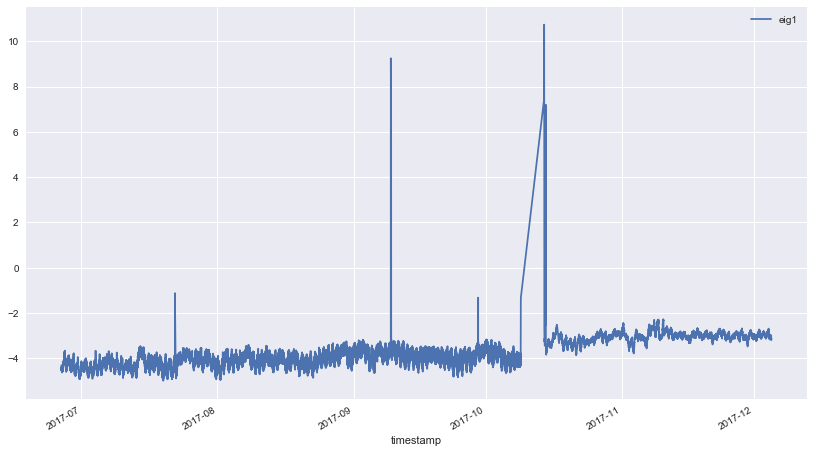

In [34]:
eig_df[eig_df.psn==39].plot(y='eig1', x = 'timestamp')
plt.show()